In [2]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd

audio_file = 'sample-000003.mp3'
babble_noise = 'babble.wav'
white_noise_file = 'white.wav'
true_mask_file = 'true_mask.csv'

In [3]:
def load_audio(file_path, sr=8000):
    return librosa.load(file_path, sr=sr)

In [4]:
def add_noise(signal, noise, snr_db):
    if len(noise) < len(signal):
        noise = np.tile(noise, int(np.ceil(len(signal) / len(noise))))
    noise = noise[:len(signal)]
    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2)
    snr_linear = 10**(snr_db / 10)
    scaling_factor = np.sqrt(signal_power / (snr_linear * noise_power))
    return signal + scaling_factor * noise

In [8]:
def estimate_noise_initial(signal, frame_length=512, hop_length=256, noise_frames=5):
    stft = librosa.stft(signal, n_fft=frame_length, hop_length=hop_length)
    magnitude_spectrogram = np.abs(stft) ** 2
    noise_estimate = np.mean(magnitude_spectrogram[:, :noise_frames], axis=1)
    return noise_estimate

In [6]:
def calculate_threshold(noise_variance, P_FA):
    return np.sqrt(2 * noise_variance * np.log(1 / P_FA))

In [7]:
def vad_magsmoothing(signal, threshold, frame_length=512, hop_length=256, forgetting_factor_mag=0.9):
    stft = librosa.stft(signal, n_fft=frame_length, hop_length=hop_length)
    magnitude_spectrogram = np.abs(stft)

    for i in range(1, magnitude_spectrogram.shape[1]):
        magnitude_spectrogram[:, i] = (magnitude_spectrogram[:, i] * (1-forgetting_factor_mag) + magnitude_spectrogram[:, i - 1] * forgetting_factor_mag)

    test_statistic = np.mean(magnitude_spectrogram, axis=0)
    threshold_1 = np.mean(threshold)
    vad_mask = test_statistic > threshold_1
    return vad_mask

In [9]:
def plot_vad(signal, vad_mask, hop_length=128, sr=16000):
    time = np.arange(len(signal)) / sr
    frame_time = np.arange(len(vad_mask)) * hop_length / sr
    plt.figure(figsize=(14, 6))
    plt.plot(time, signal, label='Signal')
    plt.plot(frame_time, vad_mask * np.max(signal), label='VAD Output', color='r', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Voice Activity Detection')
    plt.legend()
    plt.show()

In [10]:
def compute_rates(true_values, estimated_values):
    true_values, estimated_values = np.array(true_values).reshape(-1,), np.array(estimated_values)
    TP = np.sum((true_values == True) & (estimated_values == True))
    FP = np.sum((true_values == False) & (estimated_values == True))
    FN = np.sum((true_values == True) & (estimated_values == False))
    TN = np.sum((true_values == False) & (estimated_values == False))
    detection_rate = TP / (TP + FN) if (TP + FN) > 0 else 0
    false_alarm_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
    return detection_rate, false_alarm_rate

In [16]:
def plot_roc_curve(signal, noise, snr_levels, thresholds, linestyles, output_file):
    plt.figure(figsize=(6, 5))
    for snr_db, linestyle in zip(snr_levels, linestyles):
        signal_noisy = add_noise(signal, noise, snr_db)
        #noise_variance = estimate_noise_initial(signal_noisy, frame_length=64, hop_length=128, noise_frames=10)
        detection_rates, false_alarm_rates = [], []
        for threshold in thresholds:
            vad_mask = vad_magsmoothing(signal_noisy, threshold, frame_length=64, hop_length=128, forgetting_factor_mag=0.6)
            detection_rate, false_alarm_rate = compute_rates(true_vad_mask, vad_mask)
            detection_rates.append(detection_rate)
            false_alarm_rates.append(false_alarm_rate)
        plt.plot(false_alarm_rates, detection_rates, label=f'SNR = {snr_db} dB', linestyle=linestyle, linewidth=2.5)
    plt.xlabel('false-alarm probability', fontsize=15)
    plt.ylabel('speech detection probability', fontsize=15)
    plt.legend(fontsize=14)
    plt.grid()
    plt.xlim([0, 0.5])
    plt.ylim([0.5, 1])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(output_file, format='pdf')
    plt.show()

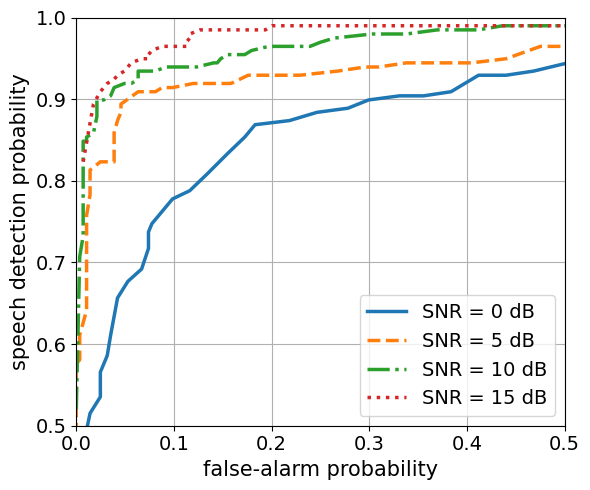

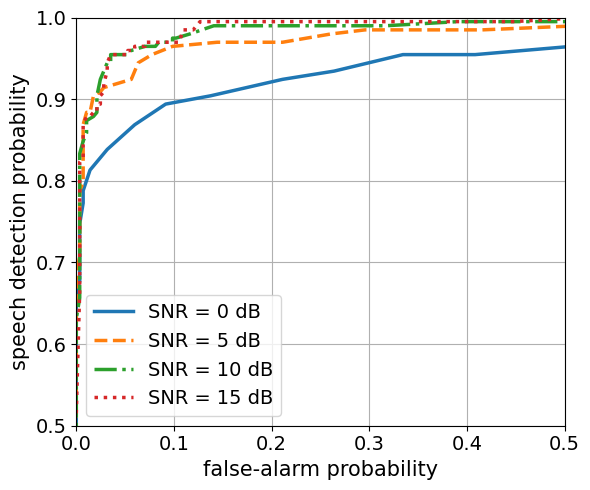

In [20]:
signal, sr = load_audio(audio_file)
true_vad_mask = np.array(pd.read_csv(true_mask_file, index_col=0)).reshape(-1,)

snr_levels = [0, 5, 10, 15]
linestyles = ['-', '--', '-.', ':']
thresholds = np.linspace(0, 0.5, 200)

noise, _ = load_audio(babble_noise)
plot_roc_curve(signal, noise, snr_levels, thresholds, linestyles, 'babble.pdf')

noise, _ = load_audio(white_noise_file)
plot_roc_curve(signal, noise, snr_levels, thresholds, linestyles, 'white.pdf')
